In [1]:
import numpy as np
import pandas as pd


# modelling
from sklearn.model_selection import train_test_split


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/telecom_users_clean.csv')

In [3]:
df.describe()

,tenure,MonthlyCharges
count,5986.000000,5986.000000
mean,32.468760,64.802213
std,24.516391,30.114702
min,0.000000,18.250000
25%,9.000000,35.650000
50%,29.000000,70.400000
75%,56.000000,89.900000
max,72.000000,118.750000


In [4]:
for col in df.columns:
  print("Column name is:", col)
  print(df[col].value_counts())

Column name is: customerID
7010-BRBUU    1
6303-KFWSL    1
5692-ICXLW    1
5561-NWEVX    1
3392-EHMNK    1
             ..
5010-IPEAQ    1
2650-GYRYL    1
5233-GEEAX    1
1573-LGXBA    1
4795-UXVCJ    1
Name: customerID, Length: 5986, dtype: int64
Column name is: gender
Male      3050
Female    2936
Name: gender, dtype: int64
Column name is: SeniorCitizen
No     5020
Yes     966
Name: SeniorCitizen, dtype: int64
Column name is: Partner
No     3082
Yes    2904
Name: Partner, dtype: int64
Column name is: Dependents
No     4195
Yes    1791
Name: Dependents, dtype: int64
Column name is: tenure
1     510
72    308
2     194
3     169
4     154
     ... 
45     47
44     47
39     44
36     43
0      10
Name: tenure, Length: 73, dtype: int64
Column name is: PhoneService
Yes    5396
No      590
Name: PhoneService, dtype: int64
Column name is: MultipleLines
No                  2848
Yes                 2548
No phone service     590
Name: MultipleLines, dtype: int64
Column name is: InternetServi

In [5]:
df=df.drop(columns=['customerID'])

In [2]:
!pip install --pre pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
df['Churn'].value_counts(normalize=True)

No     0.734881
Yes    0.265119
Name: Churn, dtype: float64

In [7]:
X = df.iloc[:,:-1]
y = df['Churn']

In [8]:
y.shape

(5986,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=19, stratify=y)

In [13]:
X_train.shape,X_test.shape

((4788, 18), (1198, 18))

In [14]:
y_train.value_counts(normalize=True)

No     0.734962
Yes    0.265038
Name: Churn, dtype: float64

In [15]:
y_test.value_counts()

No     880
Yes    318
Name: Churn, dtype: int64

In [10]:
from imblearn.over_sampling import RandomOverSampler

rus = RandomOverSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [11]:
X_train_rus.shape

(7038, 18)

In [12]:
pd.Series(y_train_rus).value_counts()

No     3519
Yes    3519
Name: Churn, dtype: int64

In [13]:
from pycaret.classification import *

reg = setup(data=pd.concat([X_train_rus,y_train_rus],axis=1), 
            target = 'Churn',          
            session_id=13, remove_multicollinearity=True, multicollinearity_threshold = 0.8,      
            experiment_name='test1',
            n_jobs=-1)

,Description,Value
0,Session id,13
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(7038, 19)"
5,Transformed data shape,"(7038, 33)"
6,Transformed train set shape,"(4926, 33)"
7,Transformed test set shape,"(2112, 33)"
8,Ordinal features,6
9,Numeric features,2


In [14]:
best_model = compare_models(fold=10, sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8618,0.9366,0.9229,0.8225,0.8697,0.7235,0.7292,1.3200
et,Extra Trees Classifier,0.8595,0.9424,0.9021,0.8314,0.8652,0.7190,0.7219,1.1380
dt,Decision Tree Classifier,0.8423,0.8485,0.9070,0.8034,0.8519,0.6845,0.6906,0.6460
lightgbm,Light Gradient Boosting Machine,0.8254,0.8920,0.8863,0.7903,0.8355,0.6508,0.6559,0.8100
gbc,Gradient Boosting Classifier,0.7779,0.8565,0.8205,0.7565,0.7870,0.5558,0.5582,1.1050
knn,K Neighbors Classifier,0.7653,0.8408,0.8567,0.7247,0.7850,0.5306,0.5400,0.7960
ada,Ada Boost Classifier,0.7669,0.8430,0.8088,0.7470,0.7764,0.5339,0.5361,0.8880
qda,Quadratic Discriminant Analysis,0.7343,0.8287,0.8819,0.6830,0.7685,0.4685,0.4933,0.6420
lr,Logistic Regression,0.7548,0.8342,0.7779,0.7438,0.7604,0.5095,0.5102,1.1390
ridge,Ridge Classifier,0.7509,0.0000,0.7844,0.7354,0.7590,0.5018,0.5031,0.5450


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [16]:
rf = create_model('rf', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8682,0.9508,0.9231,0.8321,0.8752,0.7362,0.7407
1,0.8580,0.9200,0.8947,0.8340,0.8633,0.7160,0.7179
2,0.8722,0.9395,0.9433,0.8262,0.8809,0.7443,0.7520
3,0.8560,0.9319,0.9065,0.8229,0.8627,0.7120,0.7157
4,0.8600,0.9353,0.9228,0.8195,0.8681,0.7202,0.7259
5,0.8540,0.9384,0.9187,0.8129,0.8626,0.7080,0.7140
6,0.8394,0.9199,0.9187,0.7930,0.8512,0.6789,0.6876
7,0.8740,0.9440,0.9472,0.8262,0.8826,0.7480,0.7561
8,0.8638,0.9335,0.9187,0.8278,0.8709,0.7276,0.7321


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
tuned_rf = tune_model(rf, n_iter=10, 
                      search_library='scikit-learn', 
                      search_algorithm='random',
                      custom_grid={
                          'n_estimators': [100, 200, 300, 400, 500],
                          'max_depth': [10, 15, 20, None],
                          'max_features': ['sqrt', 'log2', 0.5, 0.8]
                      },
                      optimize='f1', 
                      fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8722,0.9582,0.9271,0.8358,0.8791,0.7444,0.7489
1,0.8560,0.9270,0.8988,0.8284,0.8621,0.7119,0.7145
2,0.8682,0.9418,0.9433,0.8204,0.8776,0.7362,0.7447
3,0.8621,0.9365,0.9228,0.8225,0.8697,0.7242,0.7296
4,0.8682,0.9404,0.9268,0.8291,0.8752,0.7364,0.7415
5,0.8560,0.9328,0.9146,0.8182,0.8637,0.7120,0.7170
6,0.8435,0.9256,0.9187,0.7986,0.8544,0.6870,0.6949
7,0.8618,0.9488,0.9390,0.8134,0.8717,0.7236,0.7324
8,0.8699,0.9415,0.9187,0.8370,0.8760,0.7398,0.7434


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [18]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=13, verbose=0, warm_start=False)

In [19]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=0.8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=-1, oob_score=False,
                       random_state=13, verbose=0, warm_start=False)

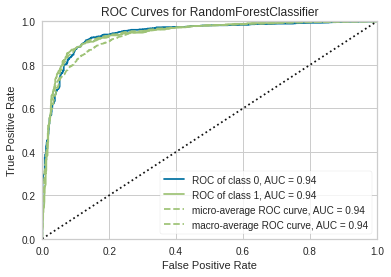

In [67]:
plot_model(tuned_rf)

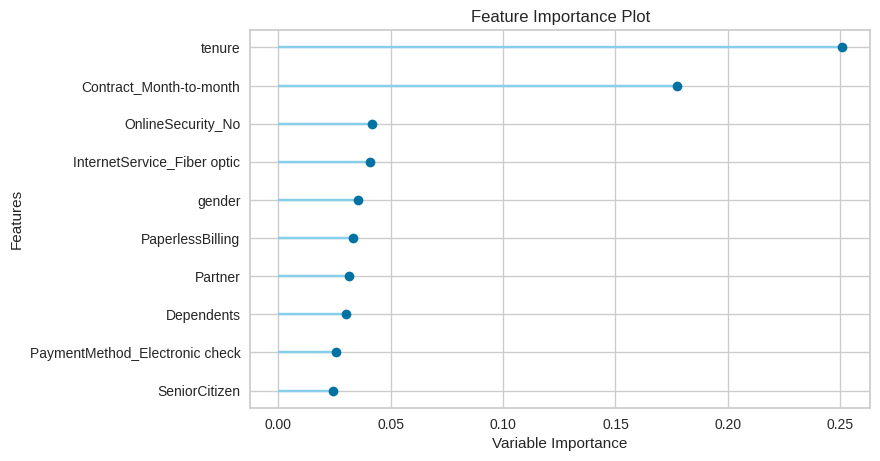

In [112]:
plot_model(tuned_rf, plot='feature')

In [ ]:
!pip install scikit-optimize

In [1]:
interpret_model(tuned_rf, plot='msa')

NameError: ignored

In [1]:
interpret_model(tuned_rf, feature="gender", plot='correlation')

NameError: ignored

In [ ]:
interpret_model(tuned_rf, feature="tenure", plot='correlation')

In [20]:
final_model = finalize_model(tuned_rf)
final_model

Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['tenure', 'MonthlyCharges'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              missing_values=nan,
                                                              strategy='mean'...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_f

In [21]:
prediction_df = predict_model(final_model, data=X_test)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [23]:
predictions = prediction_df['prediction_label']
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

          No       0.84      0.84      0.84       880
         Yes       0.56      0.56      0.56       318

    accuracy                           0.77      1198
   macro avg       0.70      0.70      0.70      1198
weighted avg       0.77      0.77      0.77      1198



,0,1
0,741,139
1,139,179


In [24]:
lr = create_model('lr', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7748,0.8739,0.7976,0.7636,0.7802,0.5497,0.5502
1,0.7566,0.8283,0.7854,0.7433,0.7638,0.5131,0.5140
2,0.7404,0.8321,0.7733,0.7262,0.7490,0.4807,0.4817
3,0.7647,0.8389,0.7805,0.7559,0.7680,0.5294,0.5297
4,0.7465,0.8289,0.7683,0.7354,0.7515,0.4929,0.4934
5,0.7566,0.8315,0.7642,0.7520,0.7581,0.5132,0.5133
6,0.7337,0.8160,0.7846,0.7122,0.7466,0.4675,0.4699
7,0.7602,0.8196,0.7805,0.7500,0.7649,0.5203,0.5208
8,0.7541,0.8406,0.7724,0.7451,0.7585,0.5081,0.5085


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
tuned_lr = tune_model(lr, n_iter=10, 
                      search_library='scikit-learn', 
                      search_algorithm='random',
                      custom_grid={
                          'penalty': ['l1','l2','none','elasticnet'],
                          'solver': ['lbfgs', 'saga', 'newton-cg','liblinear']},
                      optimize='f1',
                      fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7748,0.8739,0.7976,0.7636,0.7802,0.5497,0.5502
1,0.7586,0.8283,0.7854,0.7462,0.7653,0.5172,0.5179
2,0.7383,0.8322,0.7773,0.7218,0.7485,0.4766,0.4780
3,0.7647,0.8389,0.7805,0.7559,0.7680,0.5294,0.5297
4,0.7465,0.8288,0.7683,0.7354,0.7515,0.4929,0.4934
5,0.7566,0.8314,0.7642,0.7520,0.7581,0.5132,0.5133
6,0.7337,0.8159,0.7846,0.7122,0.7466,0.4675,0.4699
7,0.7602,0.8195,0.7805,0.7500,0.7649,0.5203,0.5208
8,0.7561,0.8405,0.7764,0.7461,0.7610,0.5122,0.5126


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [35]:
prediciton_lr_tuned = predict_model(tuned_lr, data=X_test)
predictions_lr_tuned = prediciton_lr_tuned['prediction_label']
print(classification_report(y_test, predictions_lr_tuned))
pd.DataFrame(confusion_matrix(y_test, predictions_lr_tuned))

              precision    recall  f1-score   support

          No       0.91      0.72      0.81       880
         Yes       0.51      0.81      0.63       318

    accuracy                           0.75      1198
   macro avg       0.71      0.77      0.72      1198
weighted avg       0.81      0.75      0.76      1198



,0,1
0,637,243
1,61,257


In [25]:
prediciton_lr = predict_model(lr, data=X_test)

In [26]:
predictions_lr = prediciton_lr['prediction_label']
print(classification_report(y_test, predictions_lr))
pd.DataFrame(confusion_matrix(y_test, predictions_lr))

              precision    recall  f1-score   support

          No       0.91      0.72      0.81       880
         Yes       0.52      0.81      0.63       318

    accuracy                           0.75      1198
   macro avg       0.71      0.77      0.72      1198
weighted avg       0.81      0.75      0.76      1198



,0,1
0,638,242
1,61,257


In [57]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

categorical_features = X_train_rus.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train_rus.select_dtypes(exclude=['object']).columns.tolist()

categorical_transformer = Pipeline(steps=[                                          
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])
numeric_transformer = Pipeline(steps=[                                      
                                      ("scaler", StandardScaler())
                                      ])
preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer, categorical_features)
                                               ])
lr_model=LogisticRegression(penalty='elasticnet',random_state=7,solver='saga',l1_ratio=0.3)
pipeline_lr = Pipeline(steps=[
                              ("pre_process", preprocessor), 
                              ("model", lr_model)
                              ])

In [ ]:
numeric_features

In [103]:
pipeline_lr.fit(X_train_rus, y_train_rus)

y_pred = pipeline_lr.predict(X_test)

In [104]:
features=pipeline_lr[:-1].get_feature_names_out().tolist()

In [105]:
len(features)

45

In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.91      0.73      0.81       880
         Yes       0.52      0.81      0.63       318

    accuracy                           0.75      1198
   macro avg       0.72      0.77      0.72      1198
weighted avg       0.81      0.75      0.76      1198



In [107]:
class_labels = pipeline_lr.named_steps['model'].classes_
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

,No,Yes
No,644,236
Yes,62,256


In [108]:
c=pipeline_lr['model'].coef_.tolist()

In [ ]:
c[0]


In [102]:
feature_importance=pd.DataFrame({
    'Feature': features,
    'Coef': c[0]
}).sort_values(by=['Coef'], ascending=False)
feature_importance[abs(feature_importance['Coef'])>0.25]

,Feature,Coef
16,cat__InternetService_Fiber optic,0.638337
36,cat__Contract_Month-to-month,0.486275
18,cat__OnlineSecurity_No,0.396339
32,cat__StreamingTV_Yes,0.374051
35,cat__StreamingMovies_Yes,0.291942
12,cat__MultipleLines_No,-0.270577
15,cat__InternetService_DSL,-0.275949
0,num__tenure,-0.756669
38,cat__Contract_Two year,-0.844872
